# Quantum Gates and Quantum Channels

In this tutorial, we will briefly introduce the concepts of quantum gates and quantum channels, and learn how to implement some common quantum gates and quantum channels in QuAIRKit.

**Table of Contents**

- [Quantum gates](#Quantum-gates)
  - [Single-qubit gates](#Single-qubit-gates)
  - [Two-qubit gates](#Two-qubit-gates)
  - [Applying quantum gates to states](#Applying-quantum-gates-to-states)
- [Quantum channels](#Quantum-channels)
  - [Kraus representation](#Kraus-representation)
  - [Choi representation](#Choi-representation)
  - [Stinespring representation](#Stinespring-representation)
  - [Conversion among three representations](#Conversion-among-three-representations)
  - [Examples of quantum channels](#Examples-of-quantum-channels)
    - [Bit flip channel](#Bit-flip-channel)
    - [Phase flip channel](#Phase-flip-channel)
    - [Bit-phase flip channel](#Bit-phase-flip-channel)
    - [Depolarizing channel](#Depolarizing-channel)
    - [Amplitude damping channel](#Amplitude-damping-channel)
  - [Applying quantum channels to states](#Applying-quantum-channels-to-states)

In [1]:
import torch

import quairkit as qkit
from quairkit import *
from quairkit.database.matrix import *
from quairkit.database.random import *
from quairkit.database.representation import *
from quairkit.qinfo import *

In QuAIRKit, the default datatype is `complex64`. If a higher precision `complex128` is required, it can be set as follows:

In [2]:
qkit.set_dtype("complex128")
print("dtype: ",qkit.get_dtype())

dtype:  torch.complex128


## Quantum gates

In quantum computing, a quantum gate is a basic quantum operation acting on a set of qubits. Quantum gates are the building blocks of quantum circuits, represented by unitary transformations which are reversible. Specifically, for every quantum gate $U$, there is always an another gate $U^{\dagger}$ that undoes the transformation:
$$
UU^{\dagger} = U^{\dagger}U = I, \tag{1}
$$
where $U^{\dagger}$ is the conjugate transpose of $U$. In the following, we will list some important single-qubit gates and multi-qubit gates.

### Single-qubit gates

A single-qubit is a normalized vector $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$ parameterized by two complex numbers satisfying $|\alpha|^{2}+|\beta|^{2}=1$. Quantum gates on a qubit must preserve this norm, and thus are described by $2 \times 2$ unitary matrices. Tha Pauli matrices are some of the most significant, and can be represented as:
$$
X = 
\left[
    \begin{matrix}
        0 & 1 \\
        1 & 0 
    \end{matrix}
\right]
;\quad
Y = 
\left[
    \begin{matrix}
        0 & -i \\
        i & 0 
    \end{matrix}
\right]
;\quad
Z = 
\left[
    \begin{matrix}
        1 & 0 \\
        0 & -1 
    \end{matrix}
\right]. \tag{2}
$$
One can utilize `torch` package to construct these Pauli matrices.

In [3]:
X = torch.tensor([[0, 1], [1, 0]])  # Pauli X matrix
Y = torch.tensor([[0, -1j], [1j, 0]])  # Pauli Y matrix
Z = torch.tensor([[1, 0], [0, -1]])  # Pauli Z matrix

print("The matrix form of Pauli X gate is\n", X, "\n")
print("The matrix form of Pauli Y gate is\n", Y, "\n")
print("The matrix form of Pauli Z gate is\n", Z)

The matrix form of Pauli X gate is
 tensor([[0, 1],
        [1, 0]]) 

The matrix form of Pauli Y gate is
 tensor([[0.+0.j, -0.-1.j],
        [0.+1.j, 0.+0.j]]) 

The matrix form of Pauli Z gate is
 tensor([[ 1,  0],
        [ 0, -1]])


Other three single-qubit quantum gates that play a important roles are the Hadamard gate, phase gate, and T($\pi/8$) gate:
$$
H = \frac{1}{\sqrt{2}}
\left[
    \begin{matrix}
        1 & 1 \\
        1 & -1 
    \end{matrix}
\right]
;\quad
S = 
\left[
    \begin{matrix}
        1 & 0 \\
        0 & i 
    \end{matrix}
\right]
;\quad
T = 
\left[
    \begin{matrix}
        1 & 0 \\
        0 & e^{i\pi /4} 
    \end{matrix}
\right]. \tag{3}
$$
Also, one can utilize `torch` to construct these three matrices as followed.

In [4]:
sqrt_2 = torch.sqrt(torch.tensor(2))  # sqrt 2
isq2 = 1 / sqrt_2  # 1 / sqrt 2
# pi = torch.acos(torch.zeros(1)).item() * 2 # pi

H = isq2 * torch.tensor([[1, 1], [1, -1]])  # Hadamard gate
S = torch.tensor([[1, 0], [0, 1j]])  # Phase gate
T = torch.tensor([[1, 0], [0, torch.exp(torch.tensor(1j * torch.pi / 4))]])  # T gate

print("The matrix form of Hadamard gate is\n", H)
print("\nThe matrix form of Phase gate is\n", S)
print("\nThe matrix form of T gate is\n", T)

The matrix form of Hadamard gate is
 tensor([[ 0.7071,  0.7071],
        [ 0.7071, -0.7071]])

The matrix form of Phase gate is
 tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+1.j]])

The matrix form of T gate is
 tensor([[1.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.7071+0.7071j]])


Note that the quantum gates mentioned above are built-in functions in QuAIRKit. Therefore, one can directly use these gates; for example the Hadamard gate can be constructed by QuAIRKit as follows.

In [5]:
H_qkit = h()  # built-in Hadamard gate

print("The matrix form of built in Hadamard gate is\n", H_qkit)

The matrix form of built in Hadamard gate is
 tensor([[ 0.7071+0.j,  0.7071+0.j],
        [ 0.7071+0.j, -0.7071+0.j]])


In the following introduction, built-in functions will be used for demonstration.

Besides, the Pauli matrices generate three classes of unitary rotation gates, in the direction of $x$, $y$ and $z$ axes:
$$
R_{x}(\theta) = 
\left[
    \begin{matrix}
        \cos\frac{\theta}{2} & -i\sin\frac{\theta}{2} \\
        -i\sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{matrix}
\right]
;\quad
R_{y}(\theta) = 
\left[
    \begin{matrix}
        \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
        \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{matrix}
\right]
;\quad
R_{z}(\theta) = 
\left[
    \begin{matrix}
        e^{-i\theta/2} & 0 \\
        0 & e^{i\theta/2}
    \end{matrix}
\right]. \tag{4}
$$
They can be constructed as

In [6]:
theta = torch.round(2*torch.pi*torch.rand(1), decimals=3) # the parameter of Pauli rotation operators

Rx = rx(theta) # x-axis rotation gate
Ry = ry(theta) # y-axis rotation gate
Rz = rz(theta) # z-axis rotation gate

print(f'The matrix form of x-axis rotation gate with parameter {theta[0].numpy()} is\n{Rx}')
print(f'\nThe matrix form of y-axis rotation gate with parameter {theta[0].numpy()} is\n{Ry}')
print(f'\nThe matrix form of z-axis rotation gate with parameter {theta[0].numpy()} is\n{Rz}')

The matrix form of x-axis rotation gate with parameter 2.537 is
tensor([[0.2977+0.0000j, 0.0000-0.9547j],
        [0.0000-0.9547j, 0.2977+0.0000j]])

The matrix form of y-axis rotation gate with parameter 2.537 is
tensor([[ 0.2977+0.j, -0.9547+0.j],
        [ 0.9547+0.j,  0.2977+0.j]])

The matrix form of z-axis rotation gate with parameter 2.537 is
tensor([[0.2977-0.9547j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.2977+0.9547j]])


### Two-qubit gates

A universal quantum gate set includes all single-qubit gates (such as the Pauli-X, Pauli-Y, Pauli-Z, Hadamard, and phase gates) and one two-qubit gate, like the CNOT gate.   CNOT is a quantum gate operates on two qubits: a control qubit and a target qubit. It flips the state of the target qubit if and only if the control qubit is in the state $|1\rangle$. In the computational basis, the matrix representation of CNOT is
$$
\text{CNOT} = 
\left[
    \begin{matrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 \\
        0 & 0 & 1 & 0
    \end{matrix}
\right]. \tag{5}
$$
Another important two-qubit gate is the controlled-Z gate, which applies a phase flip on the target qubit if the control qubit is in the state |1⟩, and can be represented as
$$ 
\text{CZ} =
\left[
    \begin{matrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & -1
    \end{matrix}
\right]. \tag{6}
$$
The swap gate is also a crucial two-qubit gate that exchanges the quantum states of two qubits, which we often refer to as SWAP. 
$$
\text{SWAP} = 
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 1
\end{bmatrix}. \tag{7}
$$
These two-qubit gates can be easily constructed using QuAIRKit:

In [7]:
CNOT = cnot()  # controlled-NOT gate
CZ = cz()  # controlled-Z gate
SWAP = swap()  # swap gate

print("The matrix form of controlled-NOT gate is\n", CNOT, "\n")
print("The matrix form of controlled-Z gate is\n", CZ, "\n")
print("The matrix form of swap gate is\n", SWAP)

The matrix form of controlled-NOT gate is
 tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]]) 

The matrix form of controlled-Z gate is
 tensor([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]]) 

The matrix form of swap gate is
 tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])


### Applying quantum gates to states

In quantum computing, the form of a quantum gate (unitary) $U$ acting on a pure quantum state $|\psi\rangle$ can be represented as 
$$
|\phi\rangle = U|\psi\rangle. \tag{8}
$$

More generally, the evolution of a mixed quantum state (density operator) $\rho$ under a unitary operation $U$ can be described by the equation:
$$
\sigma = U\rho U^{\dagger}. \tag{9}
$$

In QuAIRKit, applying any quantum gate to a `State` class, for both pure states and mixed states, can be achieved through `State.evolve`:

In [8]:
pure_state = random_state(num_qubits=1, rank=1) # random single-qubit pure state
mixed_state = random_state(num_qubits=1, rank=2) # random single-qubit mixed state
unitary = random_unitary(num_qubits=1) # random single-qubit unitary

pure_state_evo = pure_state.evolve(unitary)
mixed_state_evo = mixed_state.evolve(unitary)
print(f"pure output state after applying a unitary:\n {pure_state_evo.ket}\n")
print(f"mixed output state after applying a unitary:\n {mixed_state_evo.density_matrix}")

pure output state after applying a unitary:
 tensor([[0.4696+0.0464j],
        [0.5735+0.6696j]])

mixed output state after applying a unitary:
 tensor([[ 0.3775+1.3878e-17j, -0.1887+6.7681e-02j],
        [-0.1887-6.7681e-02j,  0.6225-1.3878e-17j]])


The position of the qubit on which the quantum gate acts can be specified through `sys_idx`. The dimension of a quantum gate can be smaller than the dimension of the quantum state.

In [9]:
state = random_state(num_qubits=2)
unitary = random_unitary(num_qubits=1)

state_evo = state.evolve(unitary, sys_idx=[0])
print(f"state after applying a unitary on the first qubit:\n {state_evo.density_matrix}")

state after applying a unitary on the first qubit:
 tensor([[ 0.1232+0.0000j, -0.2102+0.0393j, -0.0415+0.1123j,  0.0775-0.2049j],
        [-0.2102-0.0393j,  0.3710+0.0000j,  0.1065-0.1784j, -0.1975+0.3248j],
        [-0.0415-0.1123j,  0.1065+0.1784j,  0.1163+0.0000j, -0.2128-0.0017j],
        [ 0.0775+0.2049j, -0.1975-0.3248j, -0.2128+0.0017j,  0.3894+0.0000j]])


The application of a quantum gate on batched states is also supported.

In [10]:
state = random_state(num_qubits=1, size=5)  # 5 random single-qubit states (batched states)
unitary = random_unitary(num_qubits=1)
state_evo = state.evolve(unitary)
# this is equivalent to below code
# batch_size = 5
# state_list = []
# unitary = random_unitary(num_qubits=1)
# for i in range(batch_size):
#     state_temp = random_state(num_qubits=1)
#     state_evo_temp = state_temp.evolve(unitary)
#     state_list.append(state_evo_temp.density_matrix)
# state_evo = to_state(torch.stack(state_list, dim=0))

print(f"batched states after applying a unitary:\n {state_evo}")

batched states after applying a unitary:
 
---------------------------------------------------
 Backend: density_matrix
 System dimension: [2]
 System sequence: [0]
 Batch size: [5]

 # 0:
[[0.86-0.j   0.26-0.16j]
 [0.26+0.16j 0.14-0.j  ]]
 # 1:
[[ 0.78+0.j   -0.09-0.23j]
 [-0.09+0.23j  0.22+0.j  ]]
 # 2:
[[0.52+0.j   0.4 +0.03j]
 [0.4 -0.03j 0.48+0.j  ]]
 # 3:
[[ 0.45+0.j   -0.16+0.25j]
 [-0.16-0.25j  0.55+0.j  ]]
 # 4:
[[0.38-0.j   0.34-0.01j]
 [0.34+0.01j 0.62-0.j  ]]
---------------------------------------------------



Also, one can apply batched unitaries to a `State`.

In [11]:
state = random_state(num_qubits=1)
unitary = random_unitary(num_qubits=1, size=5) # 5 random single-qubit unitaries (batched unitaries)
state_evo = state.evolve(unitary)
# this is equivalent to below code
# batch_size = 5
# state_list = []
# state = random_state(num_qubits=1)
# for i in range(batch_size):
#     unitary_temp = random_unitary(num_qubits=1)
#     state_evo_temp = state.evolve(unitary_temp)
#     state_list.append(state_evo_temp.density_matrix)
# state_evo = to_state(torch.stack(state_list, dim=0))

print(f"state after applying batched unitaries:\n {state_evo}")

state after applying batched unitaries:
 
---------------------------------------------------
 Backend: density_matrix
 System dimension: [2]
 System sequence: [0]
 Batch size: [5]

 # 0:
[[0.11-0.j   0.19+0.17j]
 [0.19-0.17j 0.89+0.j  ]]
 # 1:
[[0.6 +0.j   0.42+0.18j]
 [0.42-0.18j 0.4 +0.j  ]]
 # 2:
[[ 0.67+0.j  -0.17-0.4j]
 [-0.17+0.4j  0.33+0.j ]]
 # 3:
[[0.11+0.j   0.07-0.25j]
 [0.07+0.25j 0.89+0.j  ]]
 # 4:
[[0.78-0.j   0.21+0.31j]
 [0.21-0.31j 0.22+0.j  ]]
---------------------------------------------------



Alternatively, one can apply quantum gates to a `State` by executing a `Circuit` object on it.

the diagram of the quantum circuit:


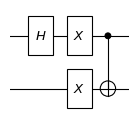

In [12]:
num_qubits = 2  # number of qubits

cir = Circuit(num_qubits)  # construct a quantum circuit
cir.h(0)  # Add Hadamard gate to qubit 0
cir.x([0, 1])  # Add X gate to qubit 0 and 1
cir.cx([0, 1])  # Add CNOT gate to qubit 0 and 1

print("the diagram of the quantum circuit:")
cir.plot()

We have constructed a quantum circuit that includes a Hadamard gate, two Pauli X gates and a CNOT gate, as shown above. We then can execute this quantum circuit on a `State`:

In [13]:
state = random_state(num_qubits=2)
output_state = cir(state)  # run the circuit on a state

print(f"output state after applying a quantum circuit:\n {output_state}")

output state after applying a quantum circuit:
 
---------------------------------------------------
 Backend: state_vector
 System dimension: [2, 2]
 System sequence: [0, 1]
[-0.2 +0.57j  0.55+0.24j -0.05-0.48j -0.22-0.06j]
---------------------------------------------------



This method also works for batched states.

In [14]:
state = random_state(num_qubits=2, size=5)  # 5 random 2-qubit states (batched states)
output_state = cir(state)  # run the circuit on batched states
# this is equivalent to below code
# batch_size = 5
# state_list = []
# for i in range(batch_size):
#     state = random_state(num_qubits=2)
#     output_state_temp = cir(state)
#     state_list.append(output_state_temp.density_matrix)
#     print(output_state_temp)
# output_states = to_state(torch.stack(state_list, dim=0))

print(f"output batched states after applying a quantum circuit:\n {output_state}")

output batched states after applying a quantum circuit:
 
---------------------------------------------------
 Backend: state_vector
 System dimension: [2, 2]
 System sequence: [0, 1]
 Batch size: [5]

 # 0:
[-0.21+0.18j -0.28-0.42j  0.3 +0.18j -0.71+0.2j ]
 # 1:
[ 0.24-0.41j  0.1 +0.62j  0.26-0.33j -0.06-0.44j]
 # 2:
[-0.57+0.04j  0.32+0.26j -0.25-0.1j   0.54+0.37j]
 # 3:
[-0.15-0.3j  -0.34-0.08j -0.  -0.43j -0.59-0.48j]
 # 4:
[-0.  +0.56j  0.61-0.1j   0.01-0.53j  0.02-0.18j]
---------------------------------------------------



The table below provides some common quantum gates that are built in QuAIRKit by name and the corresponding unitary matrices.

| Gate Name | Symbol | Matrix Presentation |
|:---:|:---:|:---:|
| Pauli X gate  |$$X$$|  $$ \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} $$ |
| Pauli Y gate  |$$Y$$|  $$ \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} $$ |
| Pauli Z gate  |$$Z$$|  $$ \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} $$ |
| Hadamard gate |$$H$$|  $$ \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} $$ |
| Phase gate |$$S$$|  $$ \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix} $$ |
| $\pi / 8$ gate |$$T$$|  $$ \begin{bmatrix} 1 & 0 \\ 0 & e^{i\pi/4} \end{bmatrix} $$ |
| $x$-axis rotation gate |$$R_{x}(\theta) $$|  $$ \begin{bmatrix} \cos\frac{\theta}{2} & -i\sin\frac{\theta}{2} \\ -i\sin\frac{\theta}{2} & \cos\frac{\theta}{2} \end{bmatrix} $$ |
| $y$-axis rotation gate |$$R_{y}(\theta)$$|  $$ \begin{bmatrix} \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\ \sin\frac{\theta}{2} & \cos\frac{\theta}{2} \end{bmatrix} $$ |
| $z$-axis rotation gate |$$R_{z}(\theta)$$|  $$ \begin{bmatrix} e^{-i\theta/2} & 0 \\ 0 & e^{i\theta/2} \end{bmatrix} $$ |
| Controlled Not gate |$$\text{CNOT}$$|  $$ \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix}$$ |
| Controlled Z gate |$$\text{CZ}$$|  $$ \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix}$$ |
| Swap gate |$$\text{SWAP}$$|  $$ \begin{bmatrix} 1 & 0 & 0 & 0 \\0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$ |

## Quantum channels

Quantum channel is a communication channel that can transmit quantum (and classical) information, which can be defined as a linear, completely positive, trace preserving (CPTP) map between two linear operator space. Quantum channel is a general formalism to describe quantum operation on quantum states. There are three types of commonly used representations of a quantum channel: Kraus, Choi, and Stinespring representations.

### Kraus representation

For a quantum channel $\mathcal{N}(\cdot)$, its Kraus representation can be expressed as:
$$
\mathcal{N}(\rho) = \sum_{i} K_{i}\rho K_{i}^{\dagger}, \tag{10}
$$

where $\{K_{i}\}$ are called the Kraus operators of the channel $\mathcal{N}$, satisfying the condition $\sum_{i}K_{i}^{\dagger}K_{i}=I$.

### Choi representation

There is another representation of a channel known as the Choi representation, or Choi operator. The Choi operator corresponding to the channel $\mathcal{N}_{A\rightarrow B}$ is given by the following expression:
$$
\Gamma^{\mathcal{N}}_{AB} = \mathcal{N}_{A^{\prime}\rightarrow B}(|\Gamma\rangle\langle\Gamma|_{AA^{\prime}}) = \sum_{i,j}|i\rangle\langle j|\otimes \mathcal{N} (|i\rangle\langle j|_{A^{\prime}}), \tag{11}
$$
wher $\mathcal{H}_{A^{\prime}}$ is isomorphic to Hilbert space $\mathcal{H}_{A}$ corresponding to the channel input system $A$, and $|\Gamma\rangle_{AA} = \sum_{i}|i,i\rangle_{AA}$. The rank of $\Gamma^{\mathcal{N}}_{AB}$ is referred to as the Choi rank of the channel $\mathcal{N}_{A\rightarrow B}$.

With the Chio operator, we can calculate the result of the channel's action. Let $\rho_{A}$ be a quantum state in the system $A$. Then the action of $\mathcal{N}_{A\rightarrow B}$ on $\rho_{A}$ can be expressed in terms of the Choi operator $\Gamma_{AB}^{\mathcal{N}}$ as follows:
$$
\mathcal{N}_{A\rightarrow B}(\rho_{A}) = \mathrm{tr}_{A}\left[(\rho_{A}^{T} \otimes I_{B}) \Gamma_{AB}^{\mathcal{N}} \right] = \langle\Gamma|_{A^{\prime}A}(\rho_{A}\otimes\Gamma_{AB}^{\mathcal{N}})|\Gamma\rangle_{A^{\prime}A}. \tag{12}
$$

### Stinespring representation

Generally speaking, the Kraus operators and the Choi operator mentioned above are the two most commonly used and fundamental representations. Additionally, for any quantum channel $\mathcal{N}: \mathcal{D}(\mathcal{H}_{A}) \rightarrow \mathcal{D}(\mathcal{H}_{B})$, and a Hilbert space $\mathcal{H}_{E}$ with a dimension equal to the Choi rank of $\mathcal{N}$, there exists an isometric transformation $V: \mathcal{H}_{A} \rightarrow \mathcal{H}_{B} \otimes \mathcal{H}_{E}$ such that for all $\rho_{A} \in \mathcal{D}(\mathcal{H}_{A})$,
$$
\mathrm{tr}_{E}(V\rho_{A}V^{\dagger}) = \mathcal{N}(\rho_{A}), \tag{13}
$$
where isometric transformation $V$ is defined by $V^{\dagger}V = I_{A}$. This is the Stinespring representation of a quantum channel.

### Conversion among three representations

Note that the three representations of a quantum channel are equivalent, and they can be converted to each other.

In [15]:
# Kraus representation of a random channel
kraus_repr = random_channel(num_qubits=1, target="kraus")

# Choi representation of the same random channel
choi_repr = channel_repr_convert(kraus_repr, source="kraus", target="choi")

# Stinespring representation of the same random channel
stin_repr = channel_repr_convert(kraus_repr, source="kraus", target="stinespring")


print(f"Kraus representation of a quantum channel:\n {kraus_repr}\n")
print(f"Choi representation of the same quantum channel:\n {choi_repr}\n")
print(f"Stinespring representation of the same quantum channel:\n {stin_repr}\n")

Kraus representation of a quantum channel:
 tensor([[[-0.5809-0.0638j,  0.2919-0.2353j],
         [-0.0027-0.5762j, -0.4139+0.0954j]],

        [[ 0.3836-0.3976j,  0.5083-0.0660j],
         [-0.1131-0.0923j, -0.3360+0.5509j]]])

Choi representation of the same quantum channel:
 tensor([[ 0.6467+0.0000j,  0.0316-0.2541j,  0.0667-0.3321j, -0.1136+0.0041j],
        [ 0.0316+0.2541j,  0.3533+0.0000j,  0.0834-0.2232j, -0.0667+0.3321j],
        [ 0.0667+0.3321j,  0.0834+0.2232j,  0.4033+0.0000j, -0.3504-0.1883j],
        [-0.1136-0.0041j, -0.0667-0.3321j, -0.3504+0.1883j,  0.5967+0.0000j]])

Stinespring representation of the same quantum channel:
 tensor([[-0.5809-0.0638j,  0.2919-0.2353j],
        [ 0.3836-0.3976j,  0.5083-0.0660j],
        [-0.0027-0.5762j, -0.4139+0.0954j],
        [-0.1131-0.0923j, -0.3360+0.5509j]])



### Examples of quantum channels

In this part, some concrete examples of quantum channels are provided.

#### Bit flip channel

The bit flip channel flips the state of a qubit from $|0\rangle$ to $|1\rangle$ or $|1\rangle$ to $|0\rangle$ with probability $1-p$. Its Kraus operators are:
$$
K_{0}=\sqrt{p}I=\sqrt{p}
\begin{bmatrix}
1&0\\
0&1
\end{bmatrix}
,\quad
K_{1}=\sqrt{1-p}X=\sqrt{1-p}
\begin{bmatrix}
0&1\\
1&0
\end{bmatrix}. \tag{14}
$$

In [16]:
probs = 0.5 # probability
bit_flip_kraus_repr = bit_flip_kraus(probs) # Kraus representation
bit_flip_choi_repr = channel_repr_convert(bit_flip_kraus_repr, source="kraus", target="choi") # Choi representation
bit_flip_stin_repr = channel_repr_convert(bit_flip_kraus_repr, source="kraus", target="stinespring") # Stinespring representation

print(f"Kraus representation of a bit flip channel with probability {probs}:\n {bit_flip_kraus_repr}\n")
print(f"Choi representation of a bit flip channel with probability {probs}:\n {bit_flip_choi_repr}\n")
print(f"Stinespring representation of a bit flip channel with probability {probs}:\n {bit_flip_stin_repr}")

Kraus representation of a bit flip channel with probability 0.5:
 tensor([[[0.7071+0.j, 0.0000+0.j],
         [0.0000+0.j, 0.7071+0.j]],

        [[0.0000+0.j, 0.7071+0.j],
         [0.7071+0.j, 0.0000+0.j]]])

Choi representation of a bit flip channel with probability 0.5:
 tensor([[0.5000+0.j, 0.0000+0.j, 0.0000+0.j, 0.5000+0.j],
        [0.0000+0.j, 0.5000+0.j, 0.5000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.5000+0.j, 0.5000+0.j, 0.0000+0.j],
        [0.5000+0.j, 0.0000+0.j, 0.0000+0.j, 0.5000+0.j]])

Stinespring representation of a bit flip channel with probability 0.5:
 tensor([[0.7071+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.7071+0.j],
        [0.0000+0.j, 0.7071+0.j],
        [0.7071+0.j, 0.0000+0.j]])


#### Phase flip channel

The phase flip channel flips the sign of the phase of a qubit with probability $1-p$. It has Kraus operators:
$$
K_{0}=\sqrt{p}I=\sqrt{p}
\begin{bmatrix}
1&0\\
0&1
\end{bmatrix}
,\quad
K_{1}=\sqrt{1-p}Z=\sqrt{1-p}
\begin{bmatrix}
1&0\\
0&-1
\end{bmatrix}. \tag{15}
$$

In [17]:
probs = 0.5 # probability
phase_flip_kraus_repr = phase_flip_kraus(probs) # Kraus representation
phase_flip_choi_repr = channel_repr_convert(phase_flip_kraus_repr, source="kraus", target="choi") # Choi representation
phase_flip_stin_repr = channel_repr_convert(phase_flip_kraus_repr, source="kraus", target="stinespring") # Stinespring representation

print(f"Kraus representation of a phase flip channel with probability {probs}:\n {phase_flip_kraus_repr}\n")
print(f"Choi representation of a phase flip channel with probability {probs}:\n {phase_flip_choi_repr}\n")
print(f"Stinespring representation of a phase flip channel with probability {probs}:\n {phase_flip_stin_repr}")

Kraus representation of a phase flip channel with probability 0.5:
 tensor([[[ 0.7071+0.j,  0.0000+0.j],
         [ 0.0000+0.j,  0.7071+0.j]],

        [[ 0.7071+0.j,  0.0000+0.j],
         [ 0.0000+0.j, -0.7071+0.j]]])

Choi representation of a phase flip channel with probability 0.5:
 tensor([[1.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 1.0000+0.j]])

Stinespring representation of a phase flip channel with probability 0.5:
 tensor([[ 0.7071+0.j,  0.0000+0.j],
        [ 0.7071+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.7071+0.j],
        [ 0.0000+0.j, -0.7071+0.j]])


#### Bit-phase flip channel

Bit-phase flip channel is the combination of phase flip and bit flip. Since $Y=iXZ$, bit-phase flip channel takes the Kraus operators
$$
K_{0}=\sqrt{p}I=\sqrt{p}
\begin{bmatrix}
1&0\\
0&1
\end{bmatrix}
,\quad
K_{1}=\sqrt{1-p}Y=\sqrt{1-p}
\begin{bmatrix}
0&-i\\
i&0
\end{bmatrix}. \tag{16}
$$

In [18]:
probs = 0.5 # probability
bit_phase_flip_kraus_repr = bit_phase_flip_kraus(probs) # Kraus representation
bit_phase_flip_choi_repr = channel_repr_convert(bit_phase_flip_kraus_repr, source="kraus", target="choi") # Choi representation
bit_phase_flip_stin_repr = channel_repr_convert(bit_phase_flip_kraus_repr, source="kraus", target="stinespring") # Stinespring representation

print(f"Kraus representation of a bit-phase flip channel with probability {probs}:\n {bit_phase_flip_kraus_repr}\n")
print(f"Choi representation of a bit-phase flip channel with probability {probs}:\n {bit_phase_flip_choi_repr}\n")
print(f"Stinespring representation of a bit-phase flip channel with probability {probs}:\n {bit_phase_flip_stin_repr}")

Kraus representation of a bit-phase flip channel with probability 0.5:
 tensor([[[0.7071+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.7071+0.0000j]],

        [[0.0000+0.0000j, 0.0000-0.7071j],
         [0.0000+0.7071j, 0.0000+0.0000j]]])

Choi representation of a bit-phase flip channel with probability 0.5:
 tensor([[ 0.5000+0.j,  0.0000+0.j,  0.0000+0.j,  0.5000+0.j],
        [ 0.0000+0.j,  0.5000+0.j, -0.5000+0.j,  0.0000+0.j],
        [ 0.0000+0.j, -0.5000+0.j,  0.5000+0.j,  0.0000+0.j],
        [ 0.5000+0.j,  0.0000+0.j,  0.0000+0.j,  0.5000+0.j]])

Stinespring representation of a bit-phase flip channel with probability 0.5:
 tensor([[0.7071+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000-0.7071j],
        [0.0000+0.0000j, 0.7071+0.0000j],
        [0.0000+0.7071j, 0.0000+0.0000j]])


#### Depolarizing channel

The depolarizing channel represents a significant type of quantum noise. Consider a single-qubit undergoing depolarization with probability $p$, namely, it is replaced by the completely mixed state $I/2$ with probability $p$. And the qubit remains unchanged with probability $1 - p$,. The state after such a depolarizing channel is
$$
\varepsilon(\rho) = \frac{pI}{2} + (1-p)\rho. \tag{17}
$$
It can be shown that the depolarizing channel has Kraus operators $\{\sqrt{1-3p'/4}I, \sqrt{p'}X/2, \sqrt{p'}Y/2, \sqrt{p'}Z/2 \}$, leading to
$$
\varepsilon(\rho) = \left(1-\frac{3p'}{4}\right)\rho+\frac{p'}{4}(X\rho X + Y\rho Y + Z\rho Z). \tag{18}
$$
There is an implementation of depolarizing channel with given parameters.

In [19]:
probs = 0.5 # probability
depolarizing_kraus_repr = depolarizing_kraus(probs) # Kraus representation
depolarizing_choi_repr = channel_repr_convert(depolarizing_kraus_repr, source="kraus", target="choi") # Choi representation
depolarizing_stin_repr = channel_repr_convert(depolarizing_kraus_repr, source="kraus", target="stinespring") # Stinespring representation

print(f"Kraus representation of a depolarizing channel with probability {probs}:\n {depolarizing_kraus_repr}\n")
print(f"Choi representation of a depolarizing channel with probability {probs}:\n {depolarizing_choi_repr}\n")
print(f"Stinespring representation of a depolarizing channel with probability {probs}:\n {depolarizing_stin_repr}")

Kraus representation of a depolarizing channel with probability 0.5:
 tensor([[[ 0.7906+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.7906+0.0000j]],

        [[ 0.0000+0.0000j,  0.3536+0.0000j],
         [ 0.3536+0.0000j,  0.0000+0.0000j]],

        [[ 0.0000+0.0000j,  0.0000-0.3536j],
         [ 0.0000+0.3536j,  0.0000+0.0000j]],

        [[ 0.3536+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j, -0.3536+0.0000j]]])

Choi representation of a depolarizing channel with probability 0.5:
 tensor([[0.7500+0.j, 0.0000+0.j, 0.0000+0.j, 0.5000+0.j],
        [0.0000+0.j, 0.2500+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.2500+0.j, 0.0000+0.j],
        [0.5000+0.j, 0.0000+0.j, 0.0000+0.j, 0.7500+0.j]])

Stinespring representation of a depolarizing channel with probability 0.5:
 tensor([[ 0.7906+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.3536+0.0000j],
        [ 0.0000+0.0000j,  0.0000-0.3536j],
        [ 0.3536+0.0000j,  0.0000+0.0000j],
      

#### Amplitude damping channel

The amplitude damping channel with decay parameter $\gamma\in[0,1]$ is the channel given with the two Kraus operators defined as
$$
K_0 = |0\rangle\langle 0| + \sqrt{1-\gamma}|1\rangle\langle 1| = 
\begin{bmatrix}
1&0\\
0&\sqrt{1-\gamma}
\end{bmatrix}
,\quad
K_{1} = \sqrt{\gamma}|0\rangle\langle 1| = 
\begin{bmatrix}
0&\sqrt{\gamma}\\
0&0
\end{bmatrix}. \tag{19}
$$
Examples of amplitude damping channel in three representations are provided.

In [20]:
gamma = 0.5 # parameter gamma
amplitude_damping_kraus_repr = amplitude_damping_kraus(gamma) # Kraus representation
amplitude_damping_choi_repr = channel_repr_convert(amplitude_damping_kraus_repr, source="kraus", target="choi") # Choi representation
amplitude_damping_stin_repr = channel_repr_convert(amplitude_damping_kraus_repr, source="kraus", target="stinespring") # Stinespring representation

print(f"Kraus representation of a amplitude damping channel with parameter {gamma}:\n {amplitude_damping_kraus_repr}\n")
print(f"Choi representation of a amplitude damping channel with parameter {gamma}:\n {amplitude_damping_choi_repr}\n")
print(f"Stinespring representation of a amplitude damping channel with parameter {gamma}:\n {amplitude_damping_stin_repr}")

Kraus representation of a amplitude damping channel with parameter 0.5:
 tensor([[[1.0000+0.j, 0.0000+0.j],
         [0.0000+0.j, 0.7071+0.j]],

        [[0.0000+0.j, 0.7071+0.j],
         [0.0000+0.j, 0.0000+0.j]]])

Choi representation of a amplitude damping channel with parameter 0.5:
 tensor([[1.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.7071+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.5000+0.j, 0.0000+0.j],
        [0.7071+0.j, 0.0000+0.j, 0.0000+0.j, 0.5000+0.j]])

Stinespring representation of a amplitude damping channel with parameter 0.5:
 tensor([[1.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.7071+0.j],
        [0.0000+0.j, 0.7071+0.j],
        [0.0000+0.j, 0.0000+0.j]])


### Applying quantum channels to states

In QuAIRKit, applying any quantum channel to a `State` class can be achieved through `State.transform`. Notice that `State.transform` does not support stinespring representations. It can be checked that the state after applying a quantum channel in Choi representation is the same as the state after applying the same quantum channel in Kraus representation.

In [21]:
state = random_state(num_qubits=1)
kraus_repr = random_channel(num_qubits=1, target="kraus") # random sigle-qubit quantum channel (Kraus representation)
choi_repr = channel_repr_convert(kraus_repr, source="kraus", target="choi") # Choi representation

state_kraus = state.transform(kraus_repr, repr_type="kraus")
state_choi = state.transform(choi_repr, repr_type="choi")

print(f"state after applying a quantum channel in Kraus representation:\n {state_kraus.density_matrix}\n")
print(f"state after applying a quantum channel in Choi representation:\n {state_choi.density_matrix}")

state after applying a quantum channel in Kraus representation:
 tensor([[0.0340+0.0000e+00j, 0.1522+9.8172e-02j],
        [0.1522-9.8172e-02j, 0.9660-1.3878e-17j]])

state after applying a quantum channel in Choi representation:
 tensor([[0.0340+0.0000j, 0.1522+0.0982j],
        [0.1522-0.0982j, 0.9660+0.0000j]])


The position of the qubit on which the quantum channel acts can be specified through `sys_idx`.

In [22]:
state = random_state(num_qubits=2)
kraus_repr = random_channel(num_qubits=1, target="kraus")

state_trans = state.transform(kraus_repr, sys_idx=[0])
print(f"state after applying a quantum channel on the first qubit:\n {state_trans.density_matrix}")

state after applying a quantum channel on the first qubit:
 tensor([[ 0.4647+0.0000e+00j,  0.1369+3.2492e-02j, -0.1272-1.2458e-01j,
          0.1082+8.6246e-02j],
        [ 0.1369-3.2492e-02j,  0.1639-1.0408e-17j, -0.0345-2.4886e-02j,
          0.0253+1.0877e-01j],
        [-0.1272+1.2458e-01j, -0.0345+2.4886e-02j,  0.1847+1.3878e-17j,
         -0.0517+5.0142e-02j],
        [ 0.1082-8.6246e-02j,  0.0253-1.0877e-01j, -0.0517-5.0142e-02j,
          0.1867-8.6736e-18j]])


For batched states, the application of a quantum channel is also supported.

In [23]:
state = random_state(num_qubits=1, size=5)  # 5 random single-qubit states (batched states)
kraus_repr = random_channel(num_qubits=1, target="kraus")
state_trans = state.transform(kraus_repr, repr_type="kraus")
# this is equivalent to below code
# batch_size = 5
# state_list = []
# kraus_repr = random_channel(num_qubits=1, target="kraus")
# for i in range(batch_size):
#     state_temp = random_state(num_qubits=1)
#     state_trans_temp = state_temp.transform(kraus_repr, repr_type="kraus")
#     state_list.append(state_trans_temp.density_matrix)
# state_trans = to_state(torch.stack(state_list, dim=0))

print(f"batched states after applying a quantum channel:\n {state_evo}")

batched states after applying a quantum channel:
 
---------------------------------------------------
 Backend: density_matrix
 System dimension: [2]
 System sequence: [0]
 Batch size: [5]

 # 0:
[[0.11-0.j   0.19+0.17j]
 [0.19-0.17j 0.89+0.j  ]]
 # 1:
[[0.6 +0.j   0.42+0.18j]
 [0.42-0.18j 0.4 +0.j  ]]
 # 2:
[[ 0.67+0.j  -0.17-0.4j]
 [-0.17+0.4j  0.33+0.j ]]
 # 3:
[[0.11+0.j   0.07-0.25j]
 [0.07+0.25j 0.89+0.j  ]]
 # 4:
[[0.78-0.j   0.21+0.31j]
 [0.21-0.31j 0.22+0.j  ]]
---------------------------------------------------



At the present, `State.transform` does not support batched quantum channels.

The table below provides some important single-qubit quantum channels that are built in QuAIRKit by name and the corresponding Kraus operators.

| Channel Name | Kraus operators |
|:---:|:---:|
| Bit flip channel | $$ \sqrt{p}\begin{bmatrix} 1&0\\0&1 \end{bmatrix}, \sqrt{1-p}\begin{bmatrix} 0&1\\1&0 \end{bmatrix}$$ |
| Phase flip channel | $$ \sqrt{p}\begin{bmatrix} 1&0\\0&1 \end{bmatrix}, \sqrt{1-p}\begin{bmatrix} 1&0\\0&-1 \end{bmatrix}$$ |
| Bit-phase flip channel | $$ \sqrt{p}\begin{bmatrix} 1&0\\0&1 \end{bmatrix}, \sqrt{1-p}\begin{bmatrix} 0&-i\\i&0 \end{bmatrix} $$ |
| Depolarizing channel | $$ \sqrt{1-\frac{3p}{4}}\begin{bmatrix}1&0\\0&1\end{bmatrix}, \sqrt{\frac{p}{4}}\begin{bmatrix}0&1\\1&0\end{bmatrix}, \sqrt{\frac{p}{4}}\begin{bmatrix}0&-i\\i&0\end{bmatrix}, \sqrt{\frac{p}{4}}\begin{bmatrix}1&0\\0&-1\end{bmatrix}$$ |
| Amplitude damping channel | $$\begin{bmatrix} 1&0\\0&\sqrt{1-\gamma} \end{bmatrix}, \begin{bmatrix} 0&\sqrt{\gamma}\\0&0 \end{bmatrix}$$ |

---

## References

[1] Nielsen, Michael A., and Isaac L. Chuang. *Quantum computation and quantum information*. Cambridge university press, 2010.

[2] Khatri, Sumeet, and Mark M. Wilde. *Principles of quantum communication theory: A modern approach*. arXiv preprint arXiv:2011.04672 (2020).

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
|$U$||unitary matrix|
| $\vert \psi \rangle$ | $\vert \phi \rangle$ | pure quantum state |
|$\rho$|$\sigma$, $\rho_{A}$|density matrix (of a quantum system $A$)|
|$\mathcal{N}_{A\rightarrow B}$|$\mathcal{N}$, $\mathcal{E}$|quantum channel (taking a quantum system $A$ to a quantum system $B$)|
|$K_{i}$||Kraus operators of a quantum channel|
|$\mathrm{tr}$|$\mathrm{tr}_{A}$|(partial) trace (on subsystem $A$)|
| $\mathcal{H}$     | $\mathcal{H}_A$      | a Hilbert space (of quantum system $A$)   |
|$\mathcal{D}(\mathcal{H})$|$\mathcal{D}(\mathcal{H}_{A})$|the set of density matrices on the Hilbert space $\mathcal{H}$ (of quantum system $A$)|
|$V$||isometric operator (or isometries)|

In [24]:
qkit.print_info()


---------VERSION---------
quairkit: 0.2.0
torch: 2.4.1+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.9.2
---------SYSTEM---------
Python version: 3.10.15
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
